In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [27]:
DIRECTORY = r"C:\Users\anand\OneDrive\Documents\GMA\Final Year Project\Facemask Detection\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [28]:
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


C:\Users\anand\anaconda3\envs\tensorflow\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

(224, 224, 3)
[-0.45098037 -0.49019605 -0.44313723]
[-0.45098037 -0.49019605 -0.44313723]


In [15]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [16]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 2s 0us/step


In [17]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [18]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
for layer in baseModel.layers:
	layer.trainable = False

In [20]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


C:\Users\anand\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 90s 904ms/step - loss: 0.3868 - accuracy: 0.8570 - val_loss: 0.1357 - val_accuracy: 0.9857
Epoch 2/20
95/95 [==============================] - 76s 797ms/step - loss: 0.1423 - accuracy: 0.9661 - val_loss: 0.0774 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 76s 803ms/step - loss: 0.0961 - accuracy: 0.9750 - val_loss: 0.0535 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 75s 788ms/step - loss: 0.0835 - accuracy: 0.9750 - val_loss: 0.0447 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 77s 811ms/step - loss: 0.0652 - accuracy: 0.9819 - val_loss: 0.0418 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 79s 831ms/step - loss: 0.0666 - accuracy: 0.9792 - val_loss: 0.0375 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 77s 806ms/step - loss: 0.0598 - accuracy: 0.9802 - val_loss: 0.036

In [22]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [23]:
predIdxs = np.argmax(predIdxs, axis=1)

In [24]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [26]:
print("[INFO] saving mask detector model...")
model.save("mask_detector1.model", save_format="h5")

[INFO] saving mask detector model...


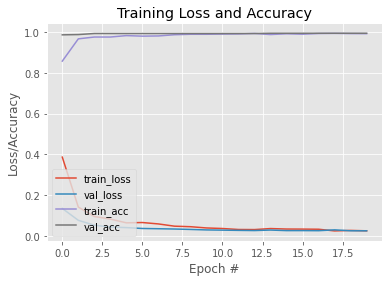

In [27]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")